<a href="https://colab.research.google.com/github/dcolbourne/Colab/blob/TensorFlow/07TransferLearninginTensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning



In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-20 21:48:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-20 21:48:41 (79.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# Import helper functions that we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

We'll use the pre-trained models from tf.keras.applications and apply them to our own problem.

https://www.tensorflow.org/api_docs/python/tf/keras/applications



In [4]:
# Get 10% of training data from the food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the data
unzip_data("10_food_classes_10_percent.zip")

--2024-12-20 21:48:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   189MB/s    in 0.9s    

2024-12-20 21:48:49 (189 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
# Check our how many images and sub dirs in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create training and test directory paths

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check our the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images , labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.45887756e+02 1.21887756e+02 7.71734695e+01]
   [1.43647964e+02 1.17719391e+02 8.04795914e+01]
   [1.51015305e+02 1.21801025e+02 9.25051041e+01]
   ...
   [5.64539566e+01 2.92396927e+01 1.96734238e+01]
   [6.19335556e+01 3.70049973e+01 3.24080696e+01]
   [5.17402878e+01 2.77402859e+01 2.44545727e+01]]

  [[1.42785706e+02 1.17857147e+02 7.66428604e+01]
   [1.39071426e+02 1.13076530e+02 7.77857208e+01]
   [1.48872452e+02 1.18928574e+02 9.12448959e+01]
   ...
   [6.09232826e+01 3.27804451e+01 2.12805099e+01]
   [5.86274567e+01 3.19029903e+01 2.31887302e+01]
   [5.03879395e+01 2.61941280e+01 1.89338913e+01]]

  [[1.39494904e+02 1.13494896e+02 7.69234695e+01]
   [1.41515305e+02 1.15515305e+02 8.23724518e+01]
   [1.44770401e+02 1.14770409e+02 8.91989746e+01]
   ...
   [7.39590073e+01 4.41937370e+01 2.73366356e+01]
   [6.73112030e+01 3.90969162e+01 2.62703915e+01]
   [5.89181061e+01 3.10609989e+01 1.94181423e+01]]

  ...

  [[2.04147980e+02 1.55147980e+02 1.23147972e+02]
   [2

## Model 0: Buidling a transfer learning model using keras functional API




In [11]:
# 1. Create a base mdoel with tf.keras.applications

from keras.applications.efficientnet_v2 import EfficientNetV2B0
import tensorflow as tf

base_model = EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (the underlying pretrained features are not upodates)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If your using ResNet50V2 you will need to normalize inputs (you don't have to for EffeicientNet)
# x =tf.keras.layers.experimental.preprocessing.Rescaling(1./225)(inputs)

# Pass the inputs to the model_0
x = base_model(inputs)
print(f"Shape after passing inputs through model_0: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x =  tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Cobine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing inputs through model_0: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20241220-204319
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 214s 9s/step - accuracy: 0.3753 - loss: 1.9874 - val_accuracy: 0.7340 - val_loss: 1.2379
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 250s 11s/step - accuracy: 0.7570 - loss: 1.1478 - val_accuracy: 0.8180 - val_loss: 0.8590
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 211s 8s/step - accuracy: 0.8222 - loss: 0.8304 - val_accuracy: 0.8392 - val_loss: 0.7024
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 0.8401 - loss: 0.6778 - val_accuracy: 0.8500 - val_loss: 0.6129
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 255s 11s/step - accuracy: 0.8641 - loss: 0.5759 - val_accuracy: 0.8556 - val_loss: 0.5574


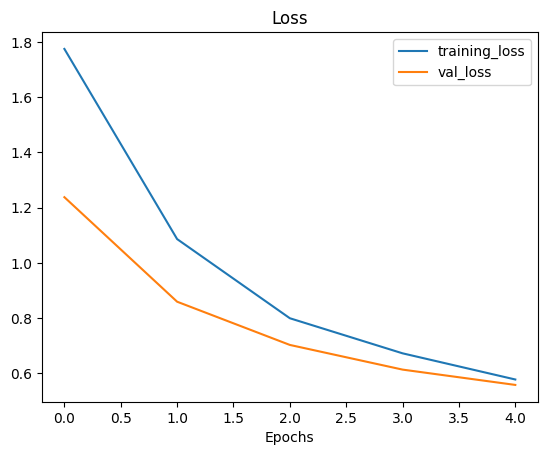

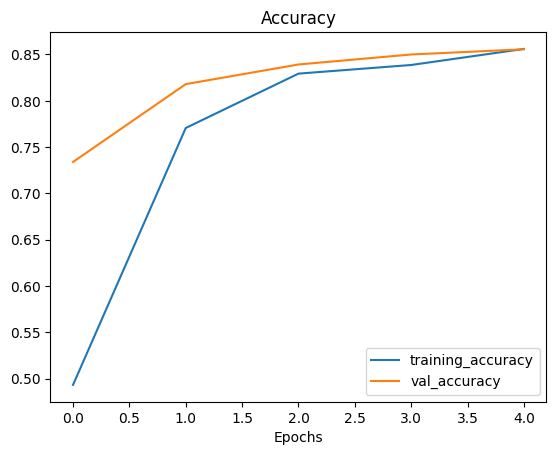

In [12]:
plot_loss_curves(history_0)

In [13]:
for layer_number, layer in enumerate(base_model.layers):
 print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [14]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [16]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8599 - loss: 0.5541


[0.5574062466621399, 0.8555999994277954]

## Getting a featue vector from a trained model

## Running a series of transfer learning experiments

How well does transger learning do with 1% of the data?

1. 'model_1' - use feature extraction transer learrning iwht 1% of the training data with data augmentation
2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.UserWarning
3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation



In [9]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-12-20 21:49:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 209.85.145.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   185MB/s    in 0.7s    

2024-12-20 21:49:32 (185 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [10]:
# Creat training and test dirs
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir_1_percent = "/content/10_food_classes_1_percent/test"

In [11]:
# How many images
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_c

In [12]:
# Setup data loaders
BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Augment the data in the model


print(tf.__version__)

We can use the layers inside:

* tf.keras.lyaers.experimental.preporocessing()

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")



### Visualize our data augmentation layer

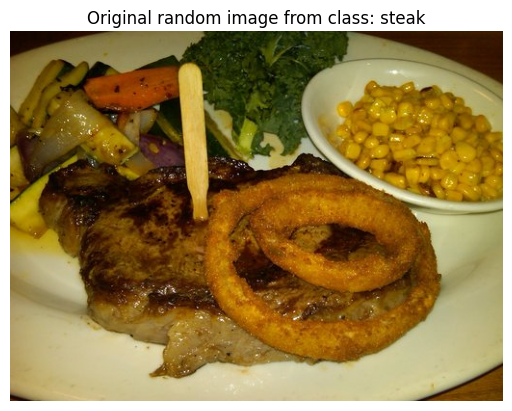

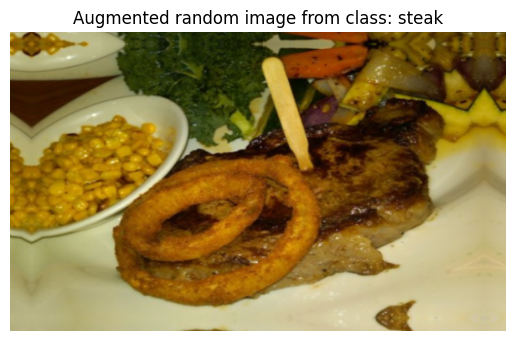

In [14]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Plot original image
plt.figure()
img = mpimg.imread(random_image_path)
plt.imshow(img/255.)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot our augmented image

plt.figure()
augmented_img = data_augmentation(img)
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model_1: Feaqture extraction transfer learning on 1% of the training data with data augmentation



In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")

# Setup input shape and base model, freezing the base layers models

input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs =layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give the base_model the inputs (after augmentation)
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = layers.Dense(10, activation="softmax", name ="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                        epochs=5,
                        validation_data=test_data_1_percent,
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction/20241220-214937
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 230s 106s/step - accuracy: 0.1118 - loss: 2.3207 - val_accuracy: 0.1288 - val_loss: 2.3046
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 259s 105s/step - accuracy: 0.1866 - loss: 2.1447 - val_accuracy: 0.1992 - val_loss: 2.1856
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 208s 103s/step - accuracy: 0.4246 - loss: 1.9734 - val_accuracy: 0.2652 - val_loss: 2.0863
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 263s 103s/step - accuracy: 0.4655 - loss: 1.8610 - val_accuracy: 0.3188 - val_loss: 1.9952
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 255s 100s/step - accuracy: 0.5449 - loss: 1.6880 - val_accuracy: 0.3752 - val_loss: 1.9080


In [18]:
model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3663 - loss: 1.9087


[1.908042550086975, 0.3752000033855438]

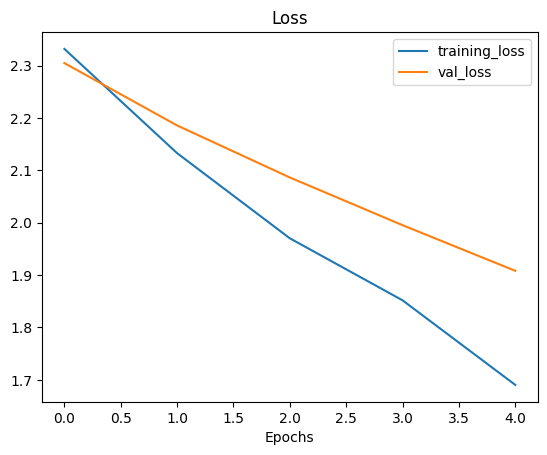

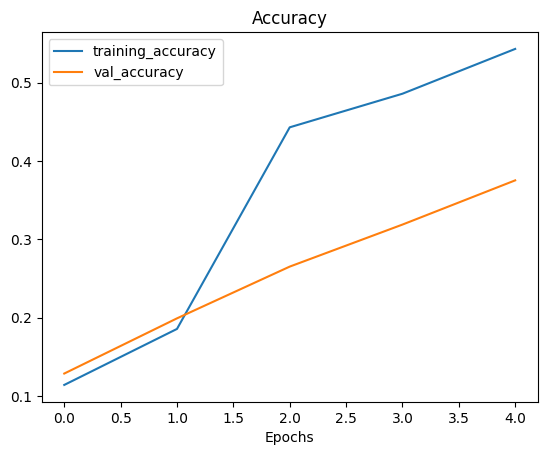

In [20]:
plot_loss_curves(history_1_percent)

In [40]:
## Modle 2: Feature extraction learning model with 10 percent data including augmentation

train_dir_10_percent = "/content/10_food_classes_10_percent/train"
test_dir_10_percent = "/content/10_food_classes_10_percent/test"

# Set up data inputs
import tensorflow as tf
from tensorflow.keras import layers
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")

input_shape = (224,224,3)
base_model = EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=(tf.keras.optimizers.Adam()),
                metrics=["accuracy"])




Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create a ModelCheckpoint callback

In [61]:
# Set the checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only = True,
                                                        save_best_only = True,
                                                        save_freq= 'epoch',
                                                        verbose=1)


In [67]:
# Fit the model
#initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = 5,
                                          validation_data=test_data,
                                          #validation_steps=(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                          experiment_name="10_percent_data_aug"),
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241220-233551
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7662 - loss: 0.9951
Epoch 1: val_loss improved from inf to 0.76143, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - accuracy: 0.7664 - loss: 0.9938 - val_accuracy: 0.8180 - val_loss: 0.7614
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7868 - loss: 0.8834
Epoch 2: val_loss improved from 0.76143 to 0.68787, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.7869 - loss: 0.8823 - val_accuracy: 0.8268 - val_loss: 0.6879
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8077 - loss: 0.7821
Epoch 3: val_loss improved from 0.68787 to 0.63736, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.8

In [68]:
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8399 - loss: 0.5804


[0.5610671639442444, 0.8443999886512756]

In [70]:
# Check modle_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8430 - loss: 0.5682


[0.5610671639442444, 0.8443999886512756]

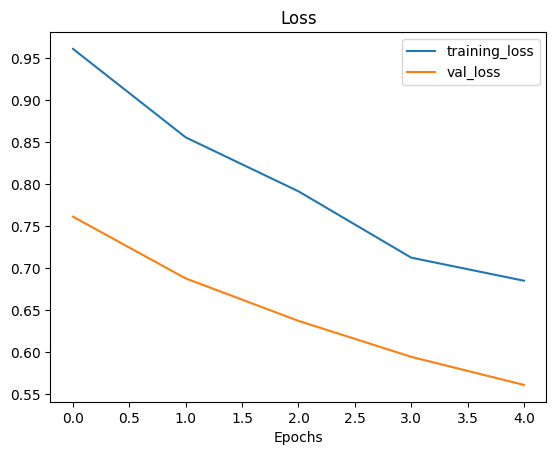

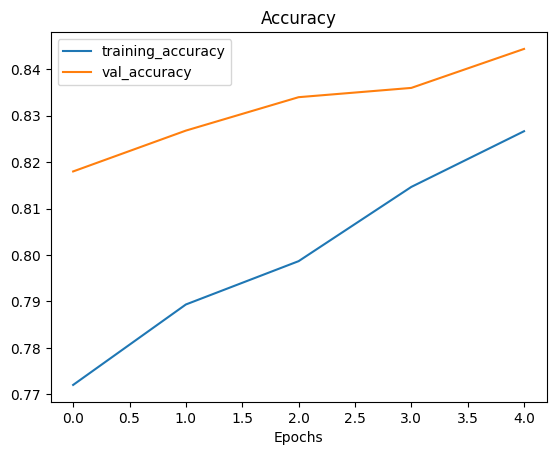

In [69]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [72]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)


In [73]:
loaded_weights_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8391 - loss: 0.5790


In [74]:
results_10_percent_data_aug == loaded_weights_results

False

In [75]:
results_10_percent_data_aug, loaded_weights_results


([0.5610671639442444, 0.8443999886512756],
 [0.5610672831535339, 0.8443999886512756])

In [76]:
# Check to see if they are very close
import numpy as np
np.isclose(results_10_percent_data_aug, loaded_weights_results)

array([ True,  True])

In [77]:
# Check difference
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_results))

[-1.1920929e-07  0.0000000e+00]
